source: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/ViTMAE/ViT_MAE_visualization_demo.ipynb

# Visualization demo: Masked Autoencoders (MAE)

In this notebook, we are going to visualize some predictions of a Vision Transformer (ViT) pre-trained on a very simple objective, namely masked patch prediction. The model needs to reconstruct pixel values for masked patches (as shown in the figure below).

<img src="https://user-images.githubusercontent.com/11435359/146857310-f258c86c-fde6-48e8-9cee-badd2b21bd2c.png" width="600" class="center"/>

* Paper: https://arxiv.org/abs/2111.06377
* Original repo (on which this notebook is based): https://github.com/facebookresearch/mae
* Video explaining the paper: https://www.youtube.com/watch?v=Dp6iICL2dVI 

## Set-up environment

In [1]:
#!pip install -q git+https://github.com/huggingface/transformers.git

## Prepare image

Here we apply some very basic image processing, namely resizing to 224x224 and normalizing the channels.

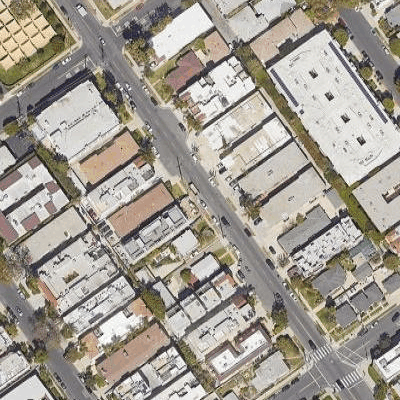

In [2]:
import requests
from PIL import Image

url = "https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg"
#image = Image.open(requests.get(url, stream=True).raw)
image = Image.open('../cil-data/training/images/satimage_2.png').convert('RGB')
image

## Visualization

Next, we forward the pixel values through the model. The encoder (which is a standard Vision Transformer) will first encode the visual patches. Next, a learnable mask token is added at the positions of the masked patches, and the decoder (which is also a Transformer) reconstructs the pixel values based on the encoded visual patches + mask tokens.

The authors saw the best performance when masking out a large portion (75%) of the image patches.

In [3]:
import torch
from transformers import ViTFeatureExtractor, ViTMAEForPreTraining

# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)

feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/vit-mae-base")
model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

print(model)

/home/felix/miniconda3/envs/cil/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ViTMAEForPreTraining(
  (vit): ViTMAEModel(
    (embeddings): ViTMAEEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
    )
    (encoder): ViTMAEEncoder(
      (layer): ModuleList(
        (0): ViTMAELayer(
          (attention): ViTMAEAttention(
            (attention): ViTMAESelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTMAEIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
     

In [4]:
# don't normalize
feature_extractor.imagenet_mean = (0,0,0)
feature_extractor.imagenet_std = (1,1,1)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

imagenet_mean = np.array(feature_extractor.image_mean)
imagenet_std = np.array(feature_extractor.image_std)

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def visualize(pixel_values, model):
    # forward pass
    outputs = model(pixel_values)
    y = model.unpatchify(outputs.logits)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    
    # visualize the mask
    mask = outputs.mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', pixel_values)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

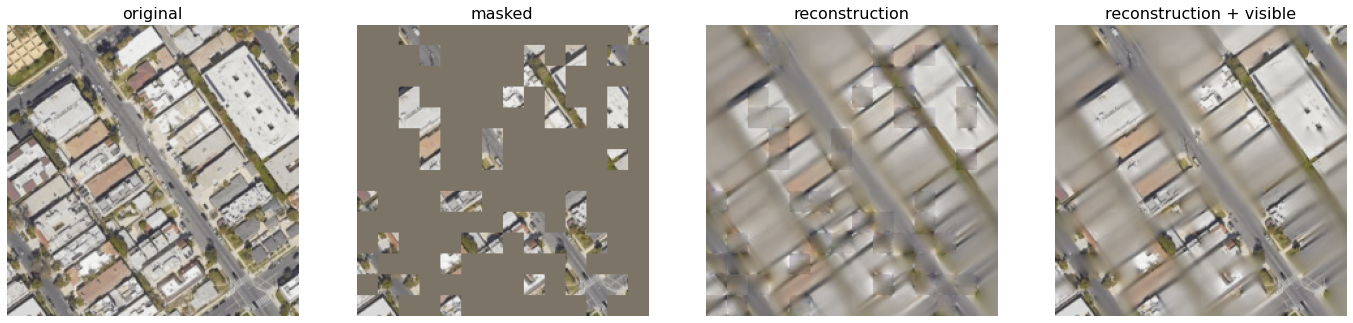

In [6]:
model.config.update({'mask_ratio':0.75})
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
visualize(pixel_values, model)

## Change Input Image Size to 400x400 

In [7]:
from transformers.models.vit_mae.modeling_vit_mae import to_2tuple, get_2d_sincos_pos_embed
import torch
from torch import nn


new_image_size = 400

# change image_size to 400 in configuration
feature_extractor.do_resize = False
model.config.update({'image_size': new_image_size})
config = model.config

# Workaround 1: update PatchEmbeddings hyperparameters (weights are not changed)
# https://github.com/huggingface/transformers/blob/main/src/transformers/models/vit_mae/modeling_vit_mae.py#L301
image_size = to_2tuple(config.image_size)
patch_size = to_2tuple(config.patch_size)
num_patches = (image_size[1] // patch_size[1]) * (image_size[0] // patch_size[0])

model.vit.embeddings.patch_embeddings.image_size = image_size
model.vit.embeddings.patch_embeddings.num_patches = num_patches

# Workaround 2: update ViTMAEEmbeddings positional embeddings (does not contain trainable weights)
# https://github.com/huggingface/transformers/blob/main/src/transformers/models/vit_mae/modeling_vit_mae.py#L215
model.vit.embeddings.num_patches = num_patches
model.vit.embeddings.position_embeddings = nn.Parameter(
    torch.zeros(1, model.vit.embeddings.num_patches + 1, config.hidden_size), requires_grad=False)
model.vit.embeddings.config = config
# model.vit.embeddings.initiallize_weights()
pos_embed = get_2d_sincos_pos_embed(
    model.vit.embeddings.position_embeddings.shape[-1], 
    int(num_patches**0.5), add_cls_token=True )
model.vit.embeddings.position_embeddings.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

# Workaround 3: update VitMAEDecoder positional embeddings (does not contain trainable weights)
# https://github.com/huggingface/transformers/blob/main/src/transformers/models/vit_mae/modeling_vit_mae.py#L741
# fixed sin-cos embedding
model.decoder.decoder_pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, config.decoder_hidden_size), requires_grad=False)  
model.decoder.config = config
# model.decoder.initialize_weights(num_patches)
decoder_pos_embed = get_2d_sincos_pos_embed(
    model.decoder.decoder_pos_embed.shape[-1], 
    int(num_patches**0.5), add_cls_token=True)
model.decoder.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))


tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.8415,  0.8020,  0.7617,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [-0.0089,  0.9986,  0.2003,  ...,  1.0000,  1.0000,  1.0000],
         [-0.8462,  0.5547,  0.8761,  ...,  1.0000,  1.0000,  1.0000],
         [-0.9056, -0.3359,  0.9349,  ...,  1.0000,  1.0000,  1.0000]]])

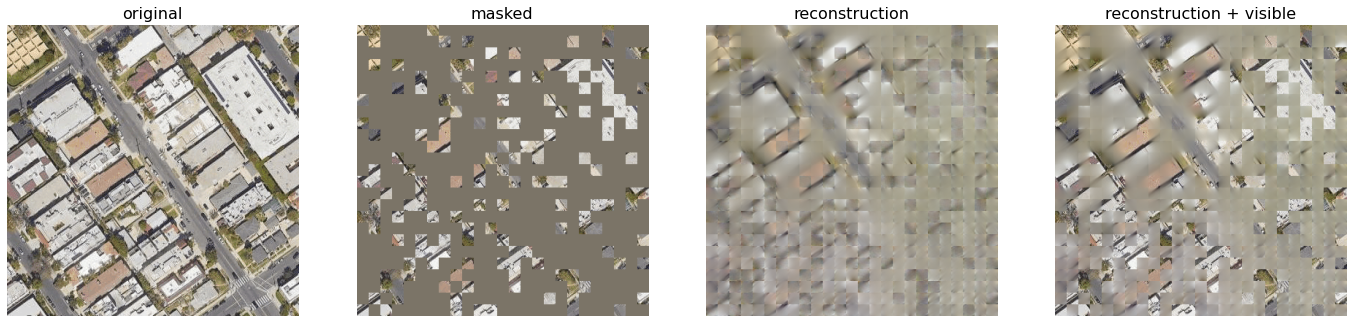

In [8]:
model.config.update({'mask_ratio':0.75})
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
visualize(pixel_values, model)

## After pre-training

Note that, after pre-training, you can directly load the weights of the encoder into a `ViTForImageClassification` and start fine-tuning/doing linear probing. Note that a warning will be printed, indicating that the weights of the decoder aren't used.

In [9]:
from transformers import ViTForImageClassification

#model = ViTForImageClassification.from_pretrained("facebook/vit-mae-base")